In [2]:
import pandas as pd
import numpy as np
import pickle
import os
import datetime
import pybamm
import matplotlib.pyplot as plt
from scipy import signal
from scipy import integrate
from scipy import interpolate
%matplotlib widget

In [3]:
XLS_FILE='GMJuly2022_CELL012_RPT_1_P25C_5P0PSI_20220907_R0_CH001_20220907220824_36_1_1_2818579438.xlsx'
VDF_FILE='GMJuly2022_CELL012_RPT_1_P25C_5P0PSI_20220907_R0_CH001.csv'

XLS_FILE='GMJuly2022_CELL047_RPT_1_P25C_25P0PSI_20220912_R0_CH004_20220912210844_36_1_4_2818579440.xlsx'
VDF_FILE='GMJuly2022_CELL047_RPT_1_P25C_25P0PSI_20220912_R0_CH004.csv'

XLS_FILE='GMJuly2022_CELL028_RPT_1_P25C_5P0PSI_20220914_R0_CH021_20220914104132_36_3_5_2818579441.xlsx'
VDF_FILE='GMJuly2022_CELL028_RPT_1_P25C_5P0PSI_20220914_R0_CH021.csv'

file_exists = os.path.exists(XLS_FILE[0:-5]+".p")
if file_exists:
    print("loading from pickle")
    neware_data_df=pickle.load( open( XLS_FILE[0:-5]+".p", "rb" ) )
else:
    print("loading from xls")
    neware_data_df = pd.read_excel(XLS_FILE, sheet_name='record')
    neware_data_df['Time'] =  pd.to_datetime(neware_data_df['Time'],format='%H:%M:%S.%f')
    pickle.dump( neware_data_df, open( XLS_FILE[0:-5]+".p", "wb" ) )

# neware_data_df = pandas.read_excel(XLS_FILE, sheet_name='record')
# neware_data_df['Time'] =  pandas.to_datetime(neware_data_df['Time'],format='%H:%M:%S.%f')
# print whole sheet data
# print(neware_data_df)

loading from pickle


In [4]:

times=neware_data_df['Total Time'].values
#A=times[222]
#B=[int(x) for x in A.split(':')]
# get hours, minutes and seconds
tm1 = [x.split(':') for x in times]
# convert to timedelta
#tm2 = [datetime.timedelta(hours=int(x[0]), minutes=int(x[1]), seconds=int(x[2])) for x in tm1]
tm2 = [60*(60*int(x[0])+int(x[1]))+float(x[2]) for x in tm1]
neware_data_df['Total Time']=tm2
# sum
#print(sum(tm2, timedelta())

In [5]:
# import pickle
# pickle.dump( neware_data_df, open( XLS_FILE[0:-5]+".p", "wb" ) )
# expansion_data= pandas.read_csv(VDF_FILE,delimiter='\t',header=0,skiprows=6,names=['Datapoint Number','Test Time','Current	Potential','Timestamp','LDC SENSOR','LDC REF','Ambient Temperature','Ambient RH','LDC N','LDC STD','REF N','REF STD','LDC scaled','LDC status','REF status','DriveCurrent','DriveCurrentRef','NAHwarn','NAHwarnRef'])
# pickle.dump( expansion_data, open( VDF_FILE[0:-4]+".p", "wb" ) )


<AxesSubplot:xlabel='Total Time'>

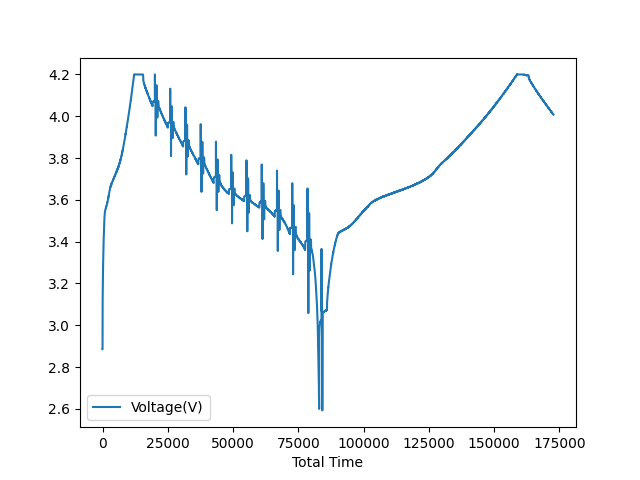

In [6]:
neware_data_df.plot(x='Total Time',y='Voltage(V)')
# expansion_data.plot(x='Timestamp',y='LDC SENSOR')

In [7]:
neware_data_df.sort_values("Total Time", inplace=True)
neware_data_df.drop_duplicates(subset=["Total Time"],inplace=True)
starttime_index=neware_data_df[neware_data_df["Current(A)"].lt(0)].index[0]-100

data_time=neware_data_df.loc[starttime_index:,"Total Time"].values
data_time = data_time-data_time[0]
data_voltage=neware_data_df.loc[starttime_index:,"Voltage(V)"].values
data_current=neware_data_df.loc[starttime_index:,"Current(A)"].values
# data_Q=neware_data_df.loc[starttime_index:,"Capacity(Ah)"].values
# data_Qd=neware_data_df.loc[starttime_index:,"DChg. Cap.(Ah)"].values
# data_Qc=neware_data_df.loc[starttime_index:,"Chg. Cap.(Ah)"].values
data_Q = integrate.cumtrapz(data_current,data_time, initial=0)/3600 #Ah
#data_time.head(10)

res = all(i < j for i, j in zip(data_time, data_time[1:]))
 
# printing result
print ("Is list strictly increasing ? : " + str(res))
nn = 10
data_time = data_time[::nn]
data_voltage = data_voltage[::nn]
data_current = data_current[::nn]
data_Q = data_Q[::nn]


Is list strictly increasing ? : True


In [8]:
model = pybamm.lithium_ion.SPMe() 

In [9]:
data_time

array([0.000000e+00, 1.000000e+01, 2.000000e+01, ..., 1.572903e+05,
       1.573003e+05, 1.573103e+05])

In [8]:
#parameter_values = model.default_parameter_values
#param["Current function [A]"] = 3
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Siegel2022)
# create interpolant
timescale = parameter_values.evaluate(model.timescale)
current_interpolant = pybamm.Interpolant(
  #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
  data_time, -data_current, timescale * pybamm.t
)

# set drive cycle
parameter_values["Current function [A]"] = current_interpolant

sim = pybamm.Simulation(model, parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(t_eval=data_time,initial_soc =.9999)
solution = sim.solution



SolverError: No value provided for input 'y'

In [ ]:
t = solution["Time [s]"].entries
V = solution["Terminal voltage [V]"].entries
I = solution["Current [A]"].entries
Q = -solution['Discharge capacity [A.h]'].entries
cs_sur_n = solution["X-averaged negative particle surface concentration"].entries
cs_sur_p = solution["X-averaged positive particle surface concentration"].entries
cs_ave_n = solution["Negative electrode volume-averaged concentration"].entries
cs_ave_p = solution["Positive electrode volume-averaged concentration"].entries

In [ ]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Siegel2022)
def graphite_diffusivity(sto, T):
    from pybamm import exp, constants
    D_ref = 1.0 * 10 ** (-15)
    E_D_s = 42770
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

parameter_values.update(
        {
            "Negative electrode diffusion coefficient [m2.s-1]": 1E-15, #5.0E-15
            "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity
        },
        check_already_exists=False,
    )
parameter_values["Current function [A]"] = current_interpolant
sim1 = pybamm.Simulation(model, parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim1.solve(t_eval=data_time,initial_soc =.9999)
solution1 = sim1.solution

In [ ]:
# model.variables.search("potential")

In [ ]:
t1 =  solution1["Time [s]"].entries
V1 =  solution1["Terminal voltage [V]"].entries
I1 =  solution1["Current [A]"].entries
Q1 = -solution1['Discharge capacity [A.h]'].entries
cs_sur_n1 = solution1["X-averaged negative particle surface concentration"].entries
cs_sur_p1 = solution1["X-averaged positive particle surface concentration"].entries
cs_ave_n1 = solution1["Negative electrode volume-averaged concentration"].entries
cs_ave_p1 = solution1["Positive electrode volume-averaged concentration"].entries

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=( 8, 4), sharex=True)
ax1 = axes.flat[0]
ax1.plot( t, cs_ave_n, 'r--', t, cs_sur_n,'r-*')
ax1.plot( t1, cs_ave_n1, 'b--', t1, cs_sur_n1,'b-*')
ax1.set_title("Negative Normalized Concentration")
# ax1.set_ylim([0.7,0.9])
ax1.set_xlabel("Time [s]")
ax2 = axes.flat[1]
ax2.plot( t, cs_ave_p, 'r--', t, cs_sur_p,'r-*')
ax2.plot( t1, cs_ave_p1, 'b--', t1, cs_sur_p1,'b-*')
ax2.set_title("Positive Normalized Concentration")
# ax2.set_ylim([0.08,0.15])
ax2.set_xlabel("Time [s]")
# ax1.set_xlim([20370,20470])
ax1.legend(['Average','Surface'])
fig.tight_layout()
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(4, 4), sharex=True)
ax1.plot(data_time, data_voltage, 'k', t, V, 'r--', t1, V1,'b--')
ax1.set_title("Voltage [V]")
# ax1.set_ylim([3.9,4.12])
ax1.set_xlabel("Time [s]")
# ax1.set_xlim([20370,20470])
ax1.legend(['data','sim'])
fig.tight_layout()
plt.show()
plt.savefig('sample_hppc_sim_zoom_2.png')

In [ ]:
# model.variables.search("potential")

In [ ]:
eta_reac_n = solution["X-averaged negative electrode reaction overpotential [V]"].entries
eta_surf_n = solution["X-averaged negative electrode surface potential difference [V]"].entries
eta_reac_p = solution["X-averaged positive electrode reaction overpotential [V]"].entries
eta_surf_p = solution["X-averaged positive electrode surface potential difference [V]"].entries
eta_elec_n = solution["X-averaged negative electrolyte potential [V]"].entries
eta_elec_p = solution["X-averaged positive electrolyte potential [V]"].entries
eta_diff = solution["Electrolyte potential [V]"].entries

In [ ]:
x = solution["x [m]"].entries

In [ ]:
len(eta_diff[0])

In [ ]:
eta_reac_n1 = solution1["X-averaged negative electrode reaction overpotential [V]"].entries
eta_surf_n1 = solution1["X-averaged negative electrode surface potential difference [V]"].entries
eta_elec_n1 = solution1["X-averaged negative electrolyte potential [V]"].entries

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4), sharex=True)
# ax1.plot(x[:,50]*1e6,eta_diff[:,50])
# ax1.plot(t,eta_diff[-1]-eta_diff[0])
ax1.plot(t,eta_elec_n+eta_surf_n)
# ax1.plot(t,eta_diff[-1])
# ax1.plot(t1,eta_reac_n1)
ax1.set_title("Negative Electrolyte Potential")
# ax1.set_ylim([3.9,4.12])
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Potential [V]")
# ax1.set_xlim([20370,20470])
# ax1.legend(['data','sim'])
fig.tight_layout()
plt.show()
# plt.savefig('sample_hppc_sim_zoom_2.png')

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4), sharex=True)
ax1.plot(t,eta_reac_n)
# ax1.plot(t1,eta_reac_n1)
ax1.set_title("Negative Electrode reaction overpotential")
# ax1.set_ylim([3.9,4.12])
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Potential [V]")
# ax1.set_xlim([20370,20470])
# ax1.legend(['data','sim'])
fig.tight_layout()
plt.show()
# plt.savefig('sample_hppc_sim_zoom_2.png')

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4), sharex=True)
ax1.plot(t,eta_reac_p)
# ax1.plot(t1,eta_reac_n1)
ax1.set_title("Positive Electrode reaction overpotential")
# ax1.set_ylim([3.9,4.12])
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Potential [V]")
# ax1.set_xlim([20370,20470])
# ax1.legend(['data','sim'])
fig.tight_layout()
plt.show()
# plt.savefig('sample_hppc_sim_zoom_2.png')

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4), sharex=True)
ax1.plot(t,eta_surf_n)
# ax1.plot(t1,eta_reac_n1)
ax1.set_title("Negative Surface Potential Difference")
# ax1.set_ylim([3.9,4.12])
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Potential [V]")
# ax1.set_xlim([20370,20470])
# ax1.legend(['data','sim'])
fig.tight_layout()
plt.show()
# plt.savefig('sample_hppc_sim_zoom_2.png')

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4), sharex=True)
ax1.plot(t,eta_surf_p)
# ax1.plot(t1,eta_reac_n1)
ax1.set_title("Positive Surface Potential Difference")
# ax1.set_ylim([3.9,4.12])
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Potential [V]")
# ax1.set_xlim([20370,20470])
# ax1.legend(['data','sim'])
fig.tight_layout()
plt.show()
# plt.savefig('sample_hppc_sim_zoom_2.png')

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax1 = axes.flat[0]
ax1.plot(data_time, data_voltage, 'k', t, V, 'r--')
ax1.set_title("Voltage [V]")
ax2 = axes.flat[1]
ax2.set_title("Capacity [Ah]")
ax2.plot(data_time, data_Q, 'k',t, Q, 'r--')
ax3 = axes.flat[2]
ax3.set_xlabel("Time [s]")
ax3.set_title("Current [A]")
ax3.plot(data_time, -data_current, 'k',t, I, 'r--')
ax1.set_xlim([15000,90000])
ax2.legend(['data','sim'])
fig.tight_layout()
plt.show()
plt.savefig('sample_hppc_sim.png')

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax1 = axes.flat[0]
ax1.plot(data_time, data_voltage, 'k', t, V, 'r--')
ax1.set_title("Voltage [V]")
# ax1.set_ylim([3.9,4.3])
ax3 = axes.flat[1]
ax3.set_xlabel("Time [s]")
ax3.set_title("Current [A]")
ax3.plot(data_time, -data_current, 'k',t, I, 'r--')
ax1.set_xlim([19000,22000])
ax3.legend(['data','sim'])
fig.tight_layout()
plt.show()
plt.savefig('sample_hppc_sim_zoom.png')

In [ ]:
xcvxcvxcv

In [ ]:
# import time 
# import datetime
# B=neware_data_df["Time"].values

# x = time.strptime(neware_data_df["Total Time"].values,'%H:%M:%S')
# datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
#A=time.strftime("%H:%M:%S",neware_data_df["Total Time"].values)

In [ ]:
experiment = pybamm.Experiment(
    [
        ("Discharge at "+"0.3A"+" for 60 min", 
         "Rest for 15 min",
         "Charge at "+ "3A"+ " for 10 sec", 
         "Rest for 5 min",
         "Discharge at "+ "3A"+ " for 10 sec", 
         "Rest for 5 min",
         "Charge at "+ "1.5A"+ " for 3.33 sec", 
         "Rest for 5 min",
         "Discharge at "+ "1.5A"+ " for 3.33 sec", 
         "Rest for 5 min",
         )
    ]*2,
#     cccv_handling="ode",
)

In [ ]:
pybamm.set_logging_level("NOTICE")
sim = pybamm.Simulation(model,parameter_values=parameter_values, experiment=experiment, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(initial_soc =.9999)
solution = sim.solution

In [ ]:
t = solution["Time [s]"].entries
V = solution["Terminal voltage [V]"].entries
I = solution["Current [A]"].entries
Q = -solution['Discharge capacity [A.h]'].entries

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
ax1 = axes.flat[0]
ax1.plot(t,V, '--')
ax1.set_title("Voltage [V]")
ax2 = axes.flat[1]
ax2.plot(t, Q, '--')
ax2.set_title("Capacity [Ah]")
ax3 = axes.flat[2]
ax3.plot(t, I, '--')
ax3.set_xlabel("Time")
ax3.set_title("Current [A]")
fig.tight_layout()
plt.savefig('sample_hppc_sim.png')